In [2]:
#load all packages
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from keras import metrics
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, image_dataset_from_directory
import cv2
import glob
from tensorflow.python.client import device_lib
from sklearn.multiclass import OneVsRestClassifier
from roc_multiclass import roc_multiclass
from precision_recall_multiclass import precision_recall_multiclass


In [20]:
# load dataset from drive
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\train"
IMAGE_SIZE = (208, 176)
train_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=False, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32,)
                                        #validation_split=0.2,
                                        #subset="training")

# one hot encode the labels to fit into the cnn layers
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))


Found 4094 files belonging to 4 classes.


In [21]:
train_big = train_ds

In [ ]:
train_big

In [73]:

for i, l in train_big.unbatch().take(1):
    print(l)


tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


In [4]:
# load dataset from drive
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\validation"
IMAGE_SIZE = (208, 176)
val_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=True, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32,)
                                        #validation_split=0.2,
                                        #subset="validation")

# one hot encode the labels to fit into the cnn layers
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

Found 1027 files belonging to 4 classes.


f:\alzheimer-classification\envwin\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


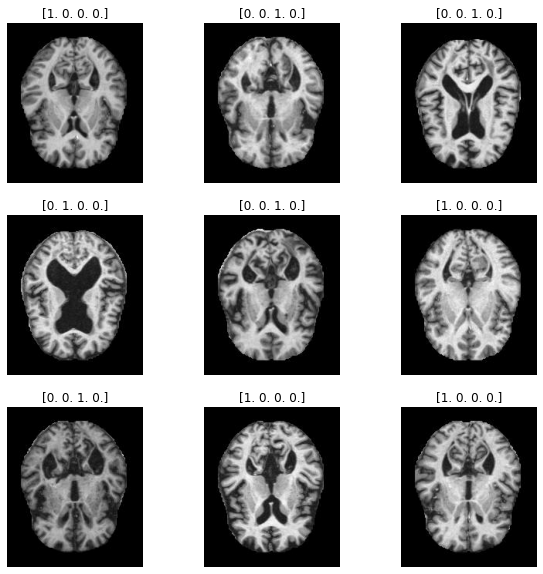

In [4]:
# # plot some example images from loaded set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title([labels[i].numpy()][0])
    plt.axis("off")

In [5]:
#iniziating model architecture
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(208, 176, 3)))
model.add(layers.Conv2D(50, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(50, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [6]:
#add dense layes to conv layers
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(4, activation="softmax"))


In [7]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=train_ds.cardinality().numpy()*100,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')


In [8]:
#compiling the model architecture and start fit
keras.backend.clear_session()
model.compile(optimizer=optimizer,
              loss="CategoricalCrossentropy",
              metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()])


with tf.device("/gpu:0"):
    history = model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=20, 
                        shuffle=True,               #not sure if used with batched tf dataset
                        )
                        
                    

Epoch 1/20
128/128 [==============================] - 9s 50ms/step - loss: 1.0741 - precision: 0.5443 - recall: 0.2489 - auc: 0.7789 - val_loss: 0.9467 - val_precision: 0.6807 - val_recall: 0.3632 - val_auc: 0.8284
Epoch 2/20
128/128 [==============================] - 6s 43ms/step - loss: 0.9266 - precision: 0.6816 - recall: 0.3534 - auc: 0.8374 - val_loss: 0.8261 - val_precision: 0.6790 - val_recall: 0.4820 - val_auc: 0.8702
Epoch 3/20
128/128 [==============================] - 6s 43ms/step - loss: 0.8206 - precision: 0.7398 - recall: 0.4438 - auc: 0.8734 - val_loss: 0.7773 - val_precision: 0.7238 - val_recall: 0.5307 - val_auc: 0.8856
Epoch 4/20
128/128 [==============================] - 6s 43ms/step - loss: 0.6920 - precision: 0.7679 - recall: 0.5755 - auc: 0.9103 - val_loss: 0.5861 - val_precision: 0.8059 - val_recall: 0.6670 - val_auc: 0.9362
Epoch 5/20
128/128 [==============================] - 6s 43ms/step - loss: 0.5655 - precision: 0.8084 - recall: 0.6800 - auc: 0.9408 - val_l

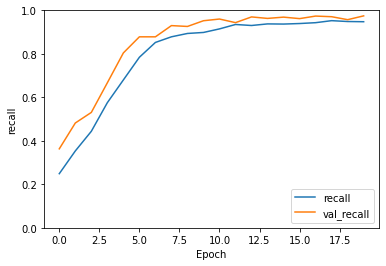

In [9]:
#print val vs accuracy

plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [10]:
# seperate images and labels for evaluation.
# !!! WARNING !!! Seperation of one entry of the dataset tensor has to seperate the img from its label
# in the same step (hence in one loop). This is because the tensor us reshuffled every time a new
# iteration starts. This would lead to wrong sorting of image to label if done one after the other

# seperation of validation set
X_val = []
y_val = []

for img, label in val_ds.unbatch():
    X_val.append(img.numpy())
    y_val.append(label.numpy())
    
X_val = np.array(X_val)
y_val = np.array(y_val)

# seperation of train set
X_train = []
y_train = []

for img, label in train_ds.unbatch():
    X_train.append(img.numpy())
    y_train.append(label.numpy())
    
X_train = np.array(X_train)
y_train = np.array(y_train)

In [11]:
y_pred = model.predict(X_val, batch_size=1, verbose=1)

test_loss, test_prec, test_rec, test_auc  = model.evaluate(val_ds, verbose=2)

1027/1027 [==============================] - 2s 1ms/step
33/33 - 1s - loss: 0.0583 - precision: 0.9882 - recall: 0.9747 - auc: 0.9994 - 586ms/epoch - 18ms/step


MACRO ROC AUC SCORE: 0.8660425182210512


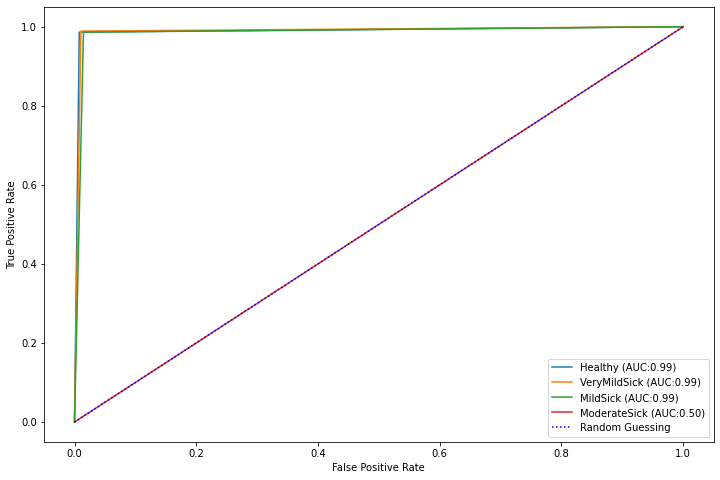

In [12]:
roc_multiclass(y_pred,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

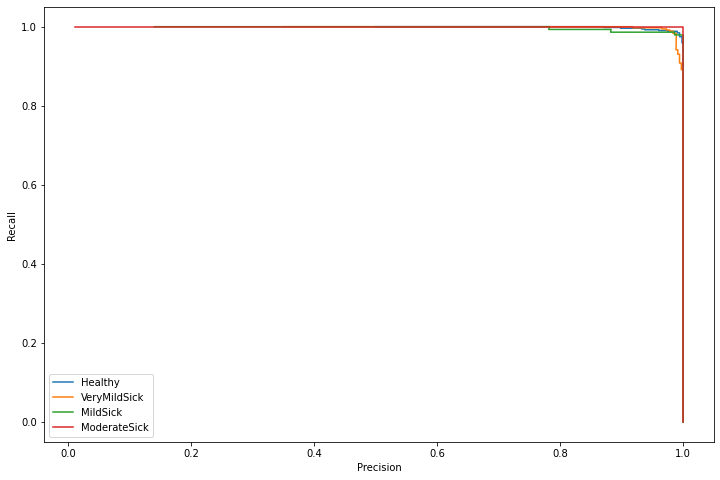

In [13]:
precision_recall_multiclass(y_pred,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

In [14]:
#!mkdir -p saved_model2
#model.save("saved_model/model2")